In [1]:
import time
import os
import shutil
import sys
import h5py
import tensorflow                 as tf
import numpy                      as np
import seaborn                    as sns
import pandas                     as pd
import numpy.random               as random
from sklearn.utils            import shuffle
from sklearn.model_selection  import train_test_split
from tqdm                     import tqdm
from os                       import path
import pysftp                     as sftp
import random                     as rnd

LocalFlg           = 'False'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
import matplotlib as mpl
import matplotlib.pyplot                      as plt
plt.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')

print("="*50)
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [2]:
WORKSPACE_PATH      = os.environ['WORKSPACE_PATH']
SurQCTFldr      = WORKSPACE_PATH + '/SurQCT/surqct/'

RatesType           = 'KExcit'
ExcitType           = 'KInel'

TTranVec = [5000.0]

MinRate             = 1.e-15

In [3]:
O2 = []
N2 = []

Molecules       = 'O2'
O2.append(Molecules)
PathToDiatFile  = WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp'   
O2.append(PathToDiatFile)
PathToHDF5File  = WORKSPACE_PATH  + '/Air_Database/HDF5_Database/O3_UMN.hdf5'
O2.append(PathToHDF5File)
PathToLevelsFile  = WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/O2_UMN_log_nd.csv'
O2.append(PathToLevelsFile)

Molecules       = 'N2'
N2.append(Molecules)
PathToDiatFile  = WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp'    
N2.append(PathToDiatFile)
PathToHDF5File  = WORKSPACE_PATH + '/Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5'
N2.append(PathToHDF5File)
PathToLevelsFile  = WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv'
N2.append(PathToLevelsFile)

In [4]:
sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

xVarsVec = ['vqn', 'log_ERot', 'log_EVib', 'jqn', 'ri', 'log_rorMin']

DiatData = read_diatdata(O2[1], O2[0], TTranVec, TTranVec)
O2.append(DiatData)
O2LevelsData=read_levelsdata(O2[3], xVarsVec, '')

DiatData = read_diatdata(N2[1], N2[0], TTranVec, TTranVec)
N2.append(DiatData)
N2LevelsData=read_levelsdata(N2[3], xVarsVec, '')

O2NLevels = 6115
N2NLevels = 9399


[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_UMN_log_nd.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LeRoy_log_nd.csv


In [5]:
def read_kexcitdata(PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}

    TStr = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
    grp  = f[TStr]

    Data  = grp["Inel"]
    KInel = Data[...]

    KOther = []
    for iProc in range(2, NProcTypes):
        ExchStr    = "Exch_" + str(iProc-1)
        Data       = grp[ExchStr] 
        KOtherTemp = Data[...]
        KOther.append(KOtherTemp)

    f.close()   


    return KInel, KOther


In [6]:
TTran = 5000
KInelMat, KExchMatList = read_kexcitdata(O2[2], TTran, TTran, 3)

if (ExcitType == 'KInel'):
    O2KExcit = KInelMat
elif (ExcitType == 'KExch'):
    O2KExcit = KExchMatList[0]
    
KInelMat, KExchMatList = read_kexcitdata(N2[2], TTran, TTran, 3)

if (ExcitType == 'KInel'):
    N2KExcit = KInelMat
elif (ExcitType == 'KExch'):
    N2KExcit = KExchMatList[0]


[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 5000K
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database_semiClassicalApprox/N3_NASA.hdf5 for Excitation Rates at Temperature 5000K


Text(0, 0.5, 'k(iLevel,j)')

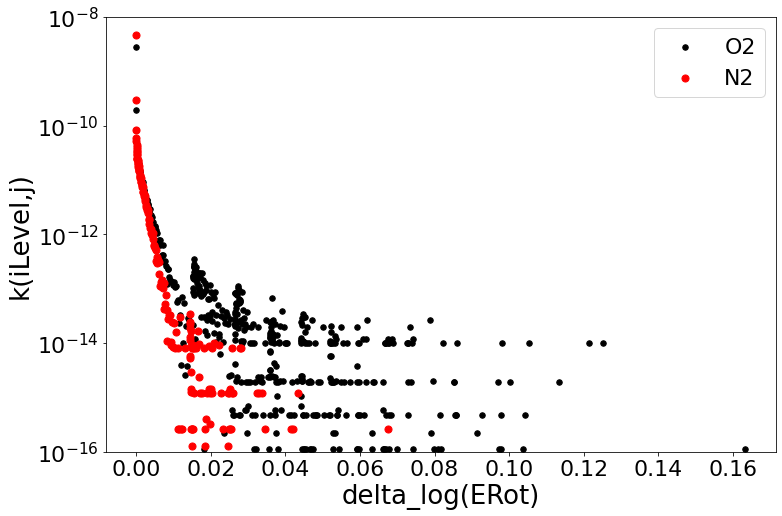

In [15]:
iIdxO2 = 0
iIdxN2 = 0
Str = 'q_'+str(int(TTran))
    
MaskO2     = O2KExcit[iIdxO2,:] > 1e-16
MaskN2     = N2KExcit[iIdxN2,:] > 1e-16

#     j_color = xTemp['jqn_j'] % 2
#     v_color = DiatData[1]['vqn'][Mask] == 1
cmap=mpl.colors.ListedColormap(["navy","crimson","limegreen","gold","k","r","b","y","c"])
cmap1=mpl.colors.ListedColormap(["k","limegreen"])
fig = plt.figure(figsize=(12,8))

O2Levels = np.linspace(0, 6115, num=6115, endpoint=False,dtype=int)
N2Levels = np.linspace(0, 9399, num=9399, endpoint=False,dtype=int)

O2delta_E = O2LevelsData['log_rorMin'] - O2LevelsData['log_rorMin'][iIdxO2]
N2delta_E = (N2LevelsData['log_rorMin'] - N2LevelsData['log_rorMin'][iIdxN2])

plt.scatter(O2delta_E[MaskO2], O2KExcit[iIdxO2,MaskO2], c='k', s=30,label='O2')
plt.scatter(N2delta_E[MaskN2], N2KExcit[iIdxN2,MaskN2], c='r', s=50,label='N2')

# plt.scatter(O2[3]['ERot'][MaskO2], O2KExcit[iIdxO2,MaskO2], c='k', s=30,label='O2')
# plt.scatter(N2[3]['ERot'][MaskN2], N2KExcit[iIdxN2,MaskN2], c='r', s=50,label='N2')

## Level Index
# plt.scatter(O2Levels[MaskO2],O2KExcit[iIdxO2,MaskO2], c='k', s=30,label='O2')
# plt.scatter(N2Levels[MaskN2],N2KExcit[iIdxN2,MaskN2], c='r', s=50,label='N2')

## EInt referenced to ground state
# plt.scatter((O2[3]['EInt'][MaskO2]-np.amin(O2[3]['EInt'])), O2KExcit[iIdxO2,MaskO2], c='k', s=30,label='O2')
# plt.scatter((N2[3]['EInt'][MaskN2]-np.amin(N2[3]['EInt'])), N2KExcit[iIdxN2,MaskN2], c='r', s=50,label='N2')

## EInt referenced to bottom of well 
# plt.scatter((O2[3]['EInt'][MaskO2]-np.amin(O2[3]['EInt'])-O2[3]['VMin'][0]), O2KExcit[iIdxO2,MaskO2], c='k', s=30,label='O2')
# plt.scatter((N2[3]['EInt'][MaskN2]-N2[3]['VMin'][0]), N2KExcit[iIdxN2,MaskN2], c='r', s=50,label='N2')

## ERot in log10
# plt.scatter(np.log10(O2[3]['ERot'][MaskO2]-np.amin(O2[3]['EInt'])-O2[3]['VMin'][0]), O2KExcit[iIdxO2,MaskO2], c='k', s=30,label='O2')
# plt.scatter(2*np.log10(N2[3]['ERot'][MaskN2]-N2[3]['VMin'][0]), N2KExcit[iIdxN2,MaskN2], c='r', s=50,label='N2')

plt.yscale('log')
plt.legend()
plt.ylim([1.e-16, 1.e-8])
plt.xlabel('delta_log(ERot)')
plt.ylabel('k(iLevel,j)')
